In [2]:
import csv
import json

import matplotlib
matplotlib.use('nbagg')
import matplotlib as mpl
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator

import numpy as np
import pandas as pd

In [3]:
# Load in the data into a multi-index frame
labels = sorted(
    open("data/baseline/label_order.csv").read().strip().split(',')
)
settings = json.load(fp=open("data/baseline/settings.json"))
n_instances = settings['n_iterations']

# Bar plot function definition

dfs : `dict`
    
    A dictionary of conditions to plot. The keys should be what you would like displayed in the legend.

cmap : `list`
    
    A list of floats indicating gray scale tone to use for each bar in a single subplot. 0 is black, 1 is white.

labels : `list`
    
    List of labels corresponding to each subplot.

In [24]:
def basic_bar_plot(dfs, cmap, labels, metric="Binary F1", keys_are_metrics=False, yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
                   yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], legend_colspan=2, legend_pos="upper left",
                   gs_rows=3, gs_cols=8, gs_params=dict(left=0.05, right=0.95, wspace=0.1, hspace=0.4), plot_subsets=False, 
                   ecolor="black", edgecolor="white", fontsize=8, subset_fontsize=7, center_left=None, center_right=None,
                   use_subset_ticks=True, n_instances=n_instances):
    
    f = plt.figure()
    gs = GridSpec(gs_rows, gs_cols)
    gs.update(**gs_params)
    axes = []
    
    for i in range(0, gs_rows):
        for j in range(0, gs_cols - legend_colspan):
            row_maj_idx = 6*i + j
            label = labels[row_maj_idx]
            print(label)

            ax = plt.subplot(gs[i, j])
            axes.append(ax)
            ax.margins(0.05)

            # Limits config
            ax.set_ylim(bottom=0.0)
            ax.set_ylim(top=1.0)

            # Ticks config
            ax.set_xticks([])
            ax.set_yticks([])

            ax.set(yticks=yticks, yticklabels=[])
            minor_ticks = MultipleLocator(0.1)
            ax.yaxis.set_minor_locator(minor_ticks)
            ax.tick_params(axis='y', which='major', direction='in', length=3.0, labelsize=8)
            ax.tick_params(axis='y', which='minor', direction='in', length=1.5, labelsize=8)
            if row_maj_idx in [0, 6, 12]:
                ax.set(yticklabels=yticklabels)

            # Title config
            ax.set_title(label.capitalize())
            ax.title.set_fontsize(fontsize)

            # plot the data for each metric, using gray-scale colors               
            # Plot testing statistics for phosphorylation and dephosphorylation
            if label in ('Phosphorylation', 'Dephosphorylation') and plot_subsets:
                gap = 0.025
                bar_width = (0.5 - gap) / len(dfs)
                validation_x = np.arange(0, 0.5 - gap, bar_width)
                holdout_x = np.arange(0.5 + gap, 1.0, bar_width)
                subset_x = {"validation": validation_x, "holdout": holdout_x}

                for idx, subset in enumerate(('validation', 'holdout')):
                    print("\t{}".format(subset))
                    for bar_idx, (key, df) in enumerate(dfs.items()):
                        metric_key = key if keys_are_metrics else metric
                        score = df.loc[(label, subset, metric_key), :].mean(axis=0, level=[0]).mean()
                        stdev = df.loc[(label, subset, metric_key), :].mean(axis=0, level=[0]).stdev()
                        stderr = stdev / np.sqrt(n_instances) # 5 bootstrap * 5 fold = 25 observations
                        print("\t\t{}: mean,stderr => {:.2f} +- {:.6f}".format(key, score, stderr))
                        ax.bar(
                            left=subset_x[subset][bar_idx], height=score, width=bar_width, yerr=stderr,
                            color=str(cmap[bar_idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                            error_kw=dict(lw=0.5, capsize=2.5, label=key)
                        )
                        
                    if not center_left:
                        center_left = validation_x[int(len(dfs) / 2)]
                    if not center_right:
                        center_right = holdout_x[int(len(dfs) / 2)]                        
                    if use_subset_ticks:
                        ax.set(xticks=[center_left, center_right], xticklabels=['Validation', 'Holdout'])
                        ax.tick_params(axis='x', direction='in', length=2.5, labelsize=subset_fontsize)

            else:
                bar_width = 1.0 / len(dfs)
                x_positions = np.arange(0, 1, bar_width)
                for idx, (key, df) in enumerate(dfs.items()):
                    metric_key = key if keys_are_metrics else metric
                    score = df.loc[(label, 'validation', metric_key), :].mean(axis=0, level=[0]).mean()
                    stdev = df.loc[(label, 'validation', metric_key), :].mean(axis=0, level=[0]).std()
                    stderr = stdev / np.sqrt(n_instances)
                    print("\t{}: mean,stderr => {:.2f} +- {:.6f}".format(key, score, stderr))
                    ax.bar(
                        left=x_positions[idx], height=score, width=bar_width, yerr=stderr,
                        color=str(cmap[idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                        error_kw=dict(lw=0.5, capsize=2.5, label=key)
                    )
                    

    # Create the legend in a separate axis object at the right end.
    ax = plt.subplot(gs[:, -legend_colspan:])
    axes.append(ax)
    lines = []
    for idx, key in enumerate(dfs.keys()):
        lines.append(mlines.Line2D([], [], color=str(cmap[idx]), label=key))
    ax.legend(handles=lines, loc=legend_pos)
    ax.set_axis_off()

    plt.show()
    return f, axes, gs

# Baseline performance

Below is the code relating to figure 2 in the publication. It's not the cleanest code, but it gets the job done.

Acetylation
	Binary F1: mean,stderr => 0.752871 +- 0.047319
Activation
	Binary F1: mean,stderr => 0.953446 +- 0.001348
Binding/association
	Binary F1: mean,stderr => 0.903245 +- 0.002990
Carboxylation
	Binary F1: mean,stderr => 1.000000 +- 0.000000
Deacetylation
	Binary F1: mean,stderr => 0.149206 +- 0.118016
Dephosphorylation
	validation


C:\Users\Daniel\Anaconda3\envs\pyppi\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


		Binary F1: mean,stderr => 0.9749 +- 0.0053
	holdout
		Binary F1: mean,stderr => 0.6387 +- 0.0153
Dissociation
	Binary F1: mean,stderr => 0.854633 +- 0.027627
Glycosylation
	Binary F1: mean,stderr => 0.962124 +- 0.033069
Inhibition
	Binary F1: mean,stderr => 0.913098 +- 0.002763
Methylation
	Binary F1: mean,stderr => 0.838288 +- 0.041303
Myristoylation
	Binary F1: mean,stderr => 1.000000 +- 0.000000
Phosphorylation
	validation
		Binary F1: mean,stderr => 0.9262 +- 0.0030
	holdout
		Binary F1: mean,stderr => 0.6948 +- 0.0114
Prenylation
	Binary F1: mean,stderr => 0.966667 +- 0.043033
Proteolytic-cleavage
	Binary F1: mean,stderr => 0.850778 +- 0.010384
State-change
	Binary F1: mean,stderr => 0.890960 +- 0.027514
Sulfation
	Binary F1: mean,stderr => 0.893175 +- 0.079104
Sumoylation
	Binary F1: mean,stderr => 0.782958 +- 0.043046
Ubiquitination
	Binary F1: mean,stderr => 0.895098 +- 0.014366


<IPython.core.display.Javascript object>


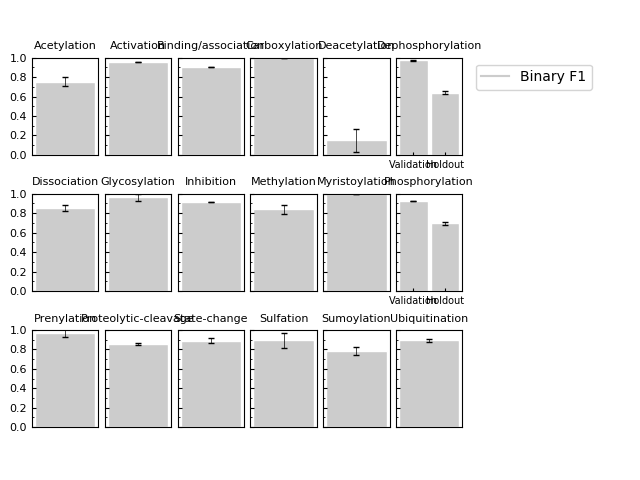

In [5]:
binary_df = pd.read_csv(
    "data/baseline/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
dfs = {
    "Binary F1": binary_df
}
cmap = [0.8, 0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, keys_are_metrics=True, plot_subsets=True);

# Random Forest

This code constructs the plot relating to the F1 score for alternate classifiers.

Acetylation
	Logistic Reg.: mean,stderr => 0.752871 +- 0.047319
	Random Forest: mean,stderr => 0.802785 +- 0.058062
Activation
	Logistic Reg.: mean,stderr => 0.953446 +- 0.001348
	Random Forest: mean,stderr => 0.974103 +- 0.002424
Binding/association
	Logistic Reg.: mean,stderr => 0.903245 +- 0.002990


C:\Users\Daniel\Anaconda3\envs\pyppi\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


	Random Forest: mean,stderr => 0.926868 +- 0.008419
Carboxylation
	Logistic Reg.: mean,stderr => 1.000000 +- 0.000000
	Random Forest: mean,stderr => 0.945455 +- 0.070418
Deacetylation
	Logistic Reg.: mean,stderr => 0.149206 +- 0.118016
	Random Forest: mean,stderr => 0.249206 +- 0.139050
Dephosphorylation
	validation
		Logistic Reg.: mean,stderr => 0.9749 +- 0.0053
		Random Forest: mean,stderr => 0.9620 +- 0.0054
	holdout
		Logistic Reg.: mean,stderr => 0.6387 +- 0.0153
		Random Forest: mean,stderr => 0.7495 +- 0.0273
Dissociation
	Logistic Reg.: mean,stderr => 0.854633 +- 0.027627
	Random Forest: mean,stderr => 0.866757 +- 0.031246
Glycosylation
	Logistic Reg.: mean,stderr => 0.962124 +- 0.033069
	Random Forest: mean,stderr => 0.899842 +- 0.046895
Inhibition
	Logistic Reg.: mean,stderr => 0.913098 +- 0.002763
	Random Forest: mean,stderr => 0.956545 +- 0.004770
Methylation
	Logistic Reg.: mean,stderr => 0.838288 +- 0.041303
	Random Forest: mean,stderr => 0.819706 +- 0.043041
Myristoylat

<IPython.core.display.Javascript object>


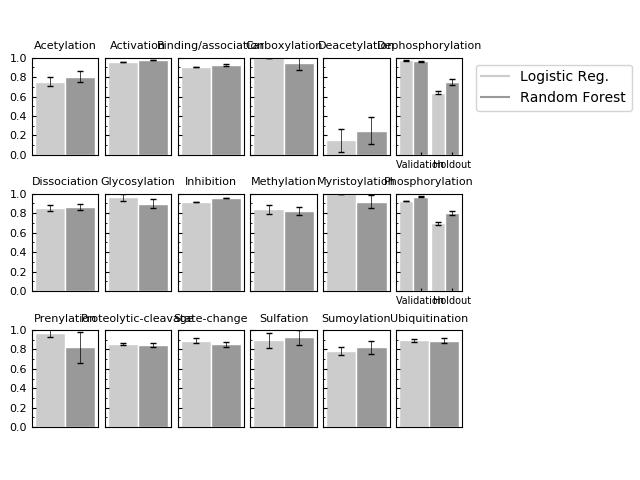

In [8]:
logistic_df = pd.read_csv(
    "data/baseline/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
rf_df = binary_df = pd.read_csv(
    "data/randomforest/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "Logistic Reg.": logistic_df,
    "Random Forest": rf_df
}
cmap = [0.8, 0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True);

# ULCA Inducer

This code computes the figure that compares ULCA induction F1 score performance using logistic regression vs no feature induction.

Acetylation
	ULCA Inducer: mean,stderr => 0.807881 +- 0.061766
	Leaf Terms: mean,stderr => 0.752871 +- 0.047319
Activation
	ULCA Inducer: mean,stderr => 0.955588 +- 0.000828
	Leaf Terms: mean,stderr => 0.953446 +- 0.001348
Binding/association
	ULCA Inducer: mean,stderr => 0.901639 +- 0.002822
	Leaf Terms: mean,stderr => 0.903245 +- 0.002990
Carboxylation
	ULCA Inducer: mean,stderr => 1.000000 +- 0.000000
	Leaf Terms: mean,stderr => 1.000000 +- 0.000000
Deacetylation
	ULCA Inducer: mean,stderr => 0.172698 +- 0.120920


C:\Users\Daniel\Anaconda3\envs\pyppi\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


	Leaf Terms: mean,stderr => 0.149206 +- 0.118016
Dephosphorylation
	validation
		ULCA Inducer: mean,stderr => 0.9744 +- 0.0036
		Leaf Terms: mean,stderr => 0.9749 +- 0.0053
	holdout
		ULCA Inducer: mean,stderr => 0.5556 +- 0.0187
		Leaf Terms: mean,stderr => 0.6387 +- 0.0153
Dissociation
	ULCA Inducer: mean,stderr => 0.866354 +- 0.023511
	Leaf Terms: mean,stderr => 0.854633 +- 0.027627
Glycosylation
	ULCA Inducer: mean,stderr => 0.949902 +- 0.038178
	Leaf Terms: mean,stderr => 0.962124 +- 0.033069
Inhibition
	ULCA Inducer: mean,stderr => 0.918378 +- 0.003326
	Leaf Terms: mean,stderr => 0.913098 +- 0.002763
Methylation
	ULCA Inducer: mean,stderr => 0.840189 +- 0.037648
	Leaf Terms: mean,stderr => 0.838288 +- 0.041303
Myristoylation
	ULCA Inducer: mean,stderr => 0.977778 +- 0.028689
	Leaf Terms: mean,stderr => 1.000000 +- 0.000000
Phosphorylation
	validation
		ULCA Inducer: mean,stderr => 0.9297 +- 0.0021
		Leaf Terms: mean,stderr => 0.9262 +- 0.0030
	holdout
		ULCA Inducer: mean,stderr 

<IPython.core.display.Javascript object>


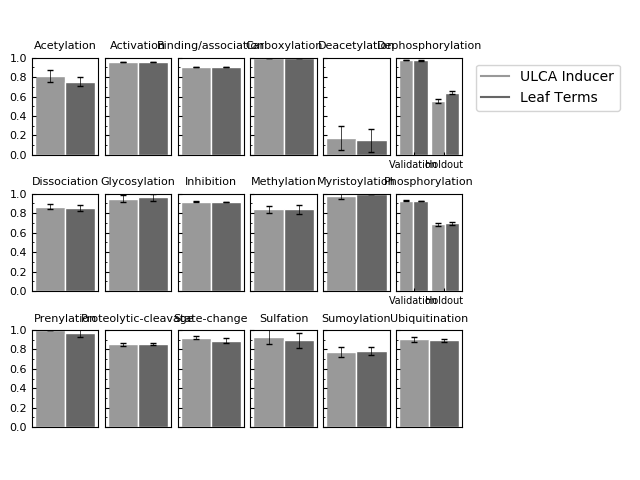

In [7]:
# TODO: GENERATE THESE DATASETS
ulca_df = pd.read_csv(
    "data/inducer/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
noulca_df = binary_df = pd.read_csv(
    "data/baseline/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "ULCA Inducer": ulca_df,
    "Leaf Terms": noulca_df
}
cmap = [0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True, center_left=0.12, center_right=0.62);

# Ternary Encoding

This code computes the figure that compares binary feature encoding F1 score performance using logistic regression vs ternary feature encoding

Acetylation
	Ternary encoding: mean,stderr => 0.781776 +- 0.072460
	Binary: mean,stderr => 0.752871 +- 0.047319
Activation
	Ternary encoding: mean,stderr => 0.942428 +- 0.001264
	Binary: mean,stderr => 0.953446 +- 0.001348
Binding/association
	Ternary encoding: mean,stderr => 0.871800 +- 0.003400
	Binary: mean,stderr => 0.903245 +- 0.002990
Carboxylation
	Ternary encoding: mean,stderr => 1.000000 +- 0.000000
	Binary: mean,stderr => 1.000000 +- 0.000000
Deacetylation
	Ternary encoding: mean,stderr => 0.224762 +- 0.139048
	Binary: mean,stderr => 0.149206 +- 0.118016
Dephosphorylation

C:\Users\Daniel\Anaconda3\envs\pyppi\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)



	validation
		Ternary encoding: mean,stderr => 0.9680 +- 0.0035
		Binary: mean,stderr => 0.9749 +- 0.0053
	holdout
		Ternary encoding: mean,stderr => 0.6038 +- 0.0162
		Binary: mean,stderr => 0.6387 +- 0.0153
Dissociation
	Ternary encoding: mean,stderr => 0.857324 +- 0.018628
	Binary: mean,stderr => 0.854633 +- 0.027627
Glycosylation
	Ternary encoding: mean,stderr => 0.938583 +- 0.028036
	Binary: mean,stderr => 0.962124 +- 0.033069
Inhibition
	Ternary encoding: mean,stderr => 0.894913 +- 0.001689
	Binary: mean,stderr => 0.913098 +- 0.002763
Methylation
	Ternary encoding: mean,stderr => 0.862212 +- 0.040354
	Binary: mean,stderr => 0.838288 +- 0.041303
Myristoylation
	Ternary encoding: mean,stderr => 0.977778 +- 0.028689
	Binary: mean,stderr => 1.000000 +- 0.000000
Phosphorylation
	validation
		Ternary encoding: mean,stderr => 0.9105 +- 0.0022
		Binary: mean,stderr => 0.9262 +- 0.0030
	holdout
		Ternary encoding: mean,stderr => 0.6570 +- 0.0074
		Binary: mean,stderr => 0.6948 +- 0.0114


<IPython.core.display.Javascript object>


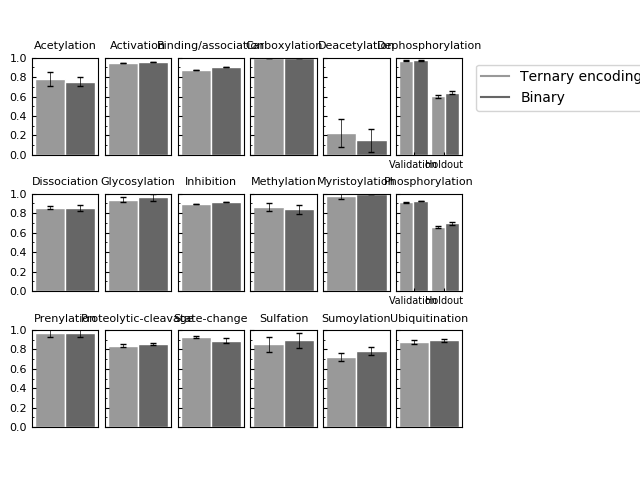

In [10]:
# TODO: GENERATE THESE DATASETS
ternary_df = pd.read_csv(
    "data/ternary/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
binary_df = pd.read_csv(
    "data/baseline/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "Ternary encoding": ternary_df,
    "Binary": binary_df
}
cmap = [0.6, 0.4]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True, center_left=0.12, center_right=0.62);

# Indiviual Feature sets

Acetylation
	GO: mean,stderr => 0.77 +- 0.061735
	Interpro: mean,stderr => 0.79 +- 0.050171
	Pfam: mean,stderr => 0.84 +- 0.038846
Activation
	GO: mean,stderr => 0.95 +- 0.001383
	Interpro: mean,stderr => 0.93 +- 0.000858
	Pfam: mean,stderr => 0.92 +- 0.001816
Binding/association
	GO: mean,stderr => 0.89 +- 0.002011
	Interpro: mean,stderr => 0.85 +- 0.003550
	Pfam: mean,stderr => 0.78 +- 0.004380
Carboxylation
	GO: mean,stderr => 1.00 +- 0.000000
	Interpro: mean,stderr => 0.98 +- 0.028689
	Pfam: mean,stderr => 1.00 +- 0.000000
Deacetylation

C:\Users\Daniel\Anaconda3\envs\pyppi\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)



	GO: mean,stderr => 0.15 +- 0.118016
	Interpro: mean,stderr => 0.23 +- 0.136610
	Pfam: mean,stderr => 0.37 +- 0.136862
Dephosphorylation
	validation
		GO: mean,stderr => 0.96 +- 0.005893
		Interpro: mean,stderr => 0.96 +- 0.003445
		Pfam: mean,stderr => 0.77 +- 0.007412
	holdout
		GO: mean,stderr => 0.53 +- 0.012430
		Interpro: mean,stderr => 0.65 +- 0.008660
		Pfam: mean,stderr => 0.62 +- 0.006717
Dissociation
	GO: mean,stderr => 0.84 +- 0.026892
	Interpro: mean,stderr => 0.73 +- 0.022651
	Pfam: mean,stderr => 0.46 +- 0.017273
Glycosylation
	GO: mean,stderr => 0.96 +- 0.033069
	Interpro: mean,stderr => 0.96 +- 0.033069
	Pfam: mean,stderr => 0.96 +- 0.033069
Inhibition
	GO: mean,stderr => 0.90 +- 0.002362
	Interpro: mean,stderr => 0.88 +- 0.003685
	Pfam: mean,stderr => 0.84 +- 0.002934
Methylation
	GO: mean,stderr => 0.81 +- 0.038711
	Interpro: mean,stderr => 0.83 +- 0.044024
	Pfam: mean,stderr => 0.32 +- 0.061754
Myristoylation
	GO: mean,stderr => 0.98 +- 0.028689
	Interpro: mean,std

<IPython.core.display.Javascript object>


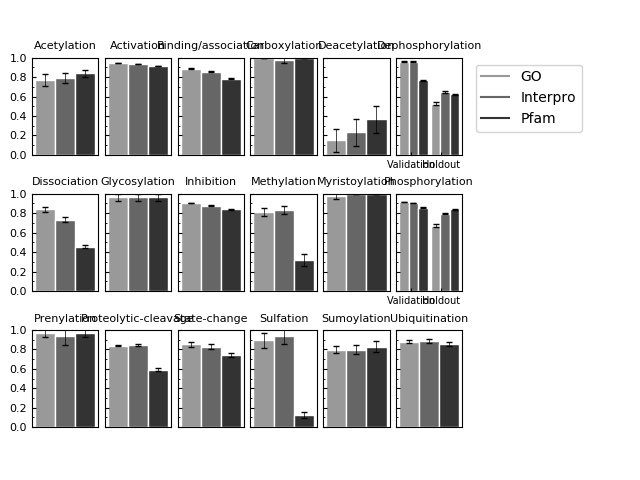

In [25]:
# TODO: GENERATE THESE DATASETS
go = pd.read_csv(
    "data/go_only//binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
ipr = pd.read_csv(
    "data/interpro_only//binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
pfam = pd.read_csv(
    "data/pfam_only//binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)

dfs = {
    "GO": go, "Interpro": ipr, "Pfam": pfam
}
cmap = [0.6, 0.4, 0.2]
basic_bar_plot(dfs, cmap, labels, plot_subsets=True, center_left=0.12, center_right=0.62);


# Label Ranking-Loss

This code computes the average ranking loss over all iterations and folds.

In [26]:
for file_name in ['baseline', 'ternary', 'inducer', 'randomforest', 'go_only', 'pfam_only', 'interpro_only']:
    ml_stats = pd.read_csv(
        "data/{}/multilabel_stats.csv".format(file_name),
        index_col=[0, 1],
        header=[0, 1]
    )
    for key in ['Label Ranking Loss', 'Hamming Loss', 'Positive Label Hamming Loss']:
        score = ml_stats.loc[("validation", key), ].mean(axis=0, level=[0]).mean()
        stdev = ml_stats.loc[("validation", key), ].std(axis=0, level=[0]).mean()
        stderr = stdev / np.sqrt(n_instances)
        print("{}\n\t{}\n\t\tmean,stderr => {:.4f} +- {:.6f}".format(file_name, key, score, stderr))

baseline
	Label Ranking Loss
		mean,stderr => 0.0553 +- 0.001451
baseline
	Hamming Loss
		mean,stderr => 0.0100 +- 0.000181
baseline
	Positive Label Hamming Loss
		mean,stderr => 0.0508 +- 0.001425
ternary
	Label Ranking Loss
		mean,stderr => 0.0633 +- 0.001243
ternary
	Hamming Loss
		mean,stderr => 0.0124 +- 0.000119
ternary
	Positive Label Hamming Loss
		mean,stderr => 0.0572 +- 0.001279
inducer
	Label Ranking Loss
		mean,stderr => 0.0563 +- 0.001405
inducer
	Hamming Loss
		mean,stderr => 0.0095 +- 0.000208
inducer
	Positive Label Hamming Loss
		mean,stderr => 0.0523 +- 0.001404
randomforest
	Label Ranking Loss
		mean,stderr => 0.0381 +- 0.002022
randomforest
	Hamming Loss
		mean,stderr => 0.0059 +- 0.000346
randomforest
	Positive Label Hamming Loss
		mean,stderr => 0.0359 +- 0.001921
go_only
	Label Ranking Loss
		mean,stderr => 0.0618 +- 0.001683
go_only
	Hamming Loss
		mean,stderr => 0.0114 +- 0.000152
go_only
	Positive Label Hamming Loss
		mean,stderr => 0.0565 +- 0.001786
pfam_on

# Specificity

This code constructs the specificity plot. The validation and holdout results are both included since specificity can still be validly defined when no positive cases exist in the dataset (as in the case with our holdout set for many labels).

Acetylation
	validation: mean,stderr => 0.9993 +- 0.0002
	holdout: mean,stderr => 0.9988 +- 0.0003
Activation
	validation: mean,stderr => 0.9323 +- 0.0029
	holdout: mean,stderr => 0.5354 +- 0.0060
Binding/association
	validation: mean,stderr => 0.9767 +- 0.0011
	holdout: mean,stderr => 0.8080 +- 0.0071
Carboxylation
	validation: mean,stderr => 1.0000 +- 0.0000
	holdout: mean,stderr => 1.0000 +- 0.0000
Deacetylation
	validation: mean,stderr => 0.9995 +- 0.0002
	holdout: mean,stderr => 0.9990 +- 0.0006
Dephosphorylation


C:\Users\Daniel\Anaconda3\envs\pyppi\lib\site-packages\matplotlib\__init__.py:1710: MatplotlibDeprecationWarning: The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0
  return func(ax, *args, **kwargs)


	validation: mean,stderr => 0.9985 +- 0.0005
	holdout: mean,stderr => 0.9814 +- 0.0014
Dissociation
	validation: mean,stderr => 0.9990 +- 0.0003
	holdout: mean,stderr => 0.9950 +- 0.0006
Glycosylation
	validation: mean,stderr => 0.9999 +- 0.0001
	holdout: mean,stderr => 0.9998 +- 0.0003
Inhibition
	validation: mean,stderr => 0.9605 +- 0.0017
	holdout: mean,stderr => 0.7945 +- 0.0065
Methylation
	validation: mean,stderr => 0.9996 +- 0.0002
	holdout: mean,stderr => 0.9990 +- 0.0005
Myristoylation
	validation: mean,stderr => 1.0000 +- 0.0000
	holdout: mean,stderr => 0.9994 +- 0.0000
Phosphorylation
	validation: mean,stderr => 0.9673 +- 0.0014
	holdout: mean,stderr => 0.9420 +- 0.0119
Prenylation
	validation: mean,stderr => 1.0000 +- 0.0000
	holdout: mean,stderr => 1.0000 +- 0.0000
Proteolytic-cleavage
	validation: mean,stderr => 0.9960 +- 0.0004
	holdout: mean,stderr => 0.9929 +- 0.0008
State-change
	validation: mean,stderr => 0.9988 +- 0.0004
	holdout: mean,stderr => 0.9992 +- 0.0004
Sul

<IPython.core.display.Javascript object>


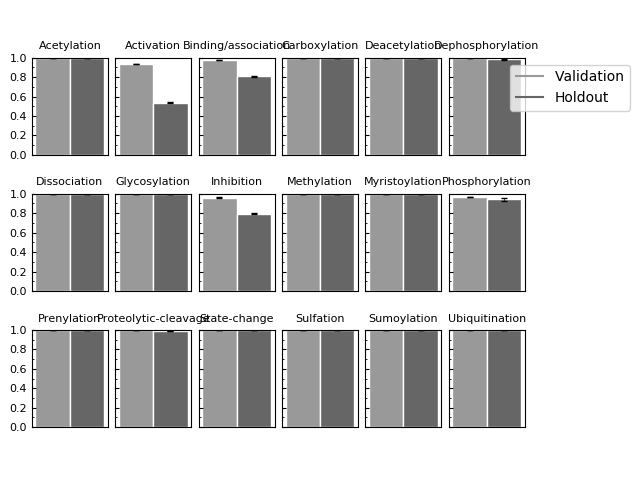

In [8]:
f = plt.figure()
binary_df = pd.read_csv(
    "data/baseline/binary_stats.csv",
    index_col=[0, 1, 2],
    header=[0, 1]
)
cmap = [0.6, 0.4]
ecolor='black'
edgecolor='white'

gs1 = GridSpec(3, 7)
gs1.update(left=0.05, right=0.95, wspace=0.1, hspace=0.4)
for i in range(0, 3):
    for j in range(0, 6):
        row_maj_idx = 6*i + j
        label = labels[row_maj_idx]
        print(label)
        
        ax = plt.subplot(gs1[i, j])
        ax.margins(0.05)
        
        # Limits config
        ax.set_ylim(bottom=0.0)
        ax.set_ylim(top=1.0)
               
        # Ticks config
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set(yticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], yticklabels=[])
        minor_ticks = MultipleLocator(0.1)
        ax.yaxis.set_minor_locator(minor_ticks)
        ax.tick_params(axis='y', which='major', direction='in', length=3.0, labelsize=8)
        ax.tick_params(axis='y', which='minor', direction='in', length=1.5, labelsize=8)
        if row_maj_idx in [0, 6, 12]:
            ax.set(yticklabels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
        
        # Title config
        ax.set_title(label.capitalize())
        ax.title.set_fontsize(8)
        
        # plot the data for each metric, using gray-scale colors               
        # Plot testing statistics for phosphorylation and dephosphorylation
        validation_x = [0.40]
        holdout_x = [0.60]
        subset_x = {"validation": validation_x, "holdout": holdout_x}
        bar_width = 0.20

        for idx, subset in enumerate(('validation', 'holdout')):
            spec = binary_df.loc[(label, subset, 'Specificity'), :].mean(axis=0, level=[0]).mean()
            stdev = binary_df.loc[(label, subset, 'Specificity'), :].std(axis=0, level=[0]).mean()
            stderr = stdev / np.sqrt(n_instances)
            print("\t{}: mean,stderr => {:.4f} +- {:.4f}".format(subset, spec, stderr))
            ax.bar(
                left=subset_x[subset][0], height=spec, width=bar_width, yerr=stderr,
                color=str(cmap[idx]), ecolor=ecolor, edgecolor=edgecolor, linewidth=1.0,
                error_kw=dict(lw=0.5, capsize=2.5, label='Specificity')
            )

# Create the legend in a separate axis object at the right end.
ax = plt.subplot(gs1[:, -1])
line1 = mlines.Line2D([], [], color=str(cmap[0]), label='Validation')
line2 = mlines.Line2D([], [], color=str(cmap[1]), label='Holdout')
ax.legend(handles=[line1, line2], loc='upper center')
ax.set_axis_off()

plt.show()

# Label Correlation Heatmap

This code produces the plot for the label correlation heatmap using the Spearman Correlation coefficient.

In [9]:
data = np.genfromtxt("data/baseline/label_spearmanr.csv", skip_header=True, delimiter=',')
ticklabels = [l.capitalize() for l in labels]
fig, ax = plt.subplots(1, 1)
# ax.xaxis.tick_top()

ax.set_xticks(range(0, 18))
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontdict={'size': 10})

ax.set_yticks(range(0, 18))
ax.set_yticklabels(ticklabels, fontdict={'size': 10})

im = ax.imshow(data, interpolation='none', cmap='RdBu', vmin=-1, vmax=1)
fig.colorbar(im, ticks=[-1., -0.5, 0., 0.5, 1.])
ax.text(-0.1, 1.1, '(a)', transform=ax1.transAxes, size=12)

plt.tight_layout()
plt.savefig('spearman.jpg', format='jpg', dpi=350, bbox_inches='tight', pad_inches=0.1)
plt.show()


data = np.genfromtxt("data/baseline/j_v_similarity_matrix.csv", skip_header=True, delimiter=',')
ticklabels = [l.capitalize() for l in labels]
fig, ax = plt.subplots(1, 1)

ax.set_xticks(range(0, 18))
ax.set_xticklabels(ticklabels, rotation=45, ha='right', fontdict={'size': 10})

ax.set_yticks(range(0, 18))
ax.set_yticklabels(ticklabels, fontdict={'size': 10})
plt.setp(ax.get_yticklabels(), visible=False)

im = ax.imshow(data, interpolation='none', cmap='RdPu', vmin=0, vmax=1)
fig.colorbar(im, ticks=[-1., -0.5, 0., 0.5, 1.])
ax.text(0.3, 1.1, '(b)', transform=ax1.transAxes, size=12)

plt.tight_layout()
plt.savefig('jaccard.jpg', format='jpg', dpi=350)
plt.show()

NameError: name 'ax1' is not defined

# Label Similarity Heatmaps

This code produces the plot for the label feature similarity heatmap using the Jaccard similarity measure.

The right subplot is the label feature similarity heatmap using the Jaccard similarity measure on the labels in the holdout set only.

<IPython.core.display.Javascript object>


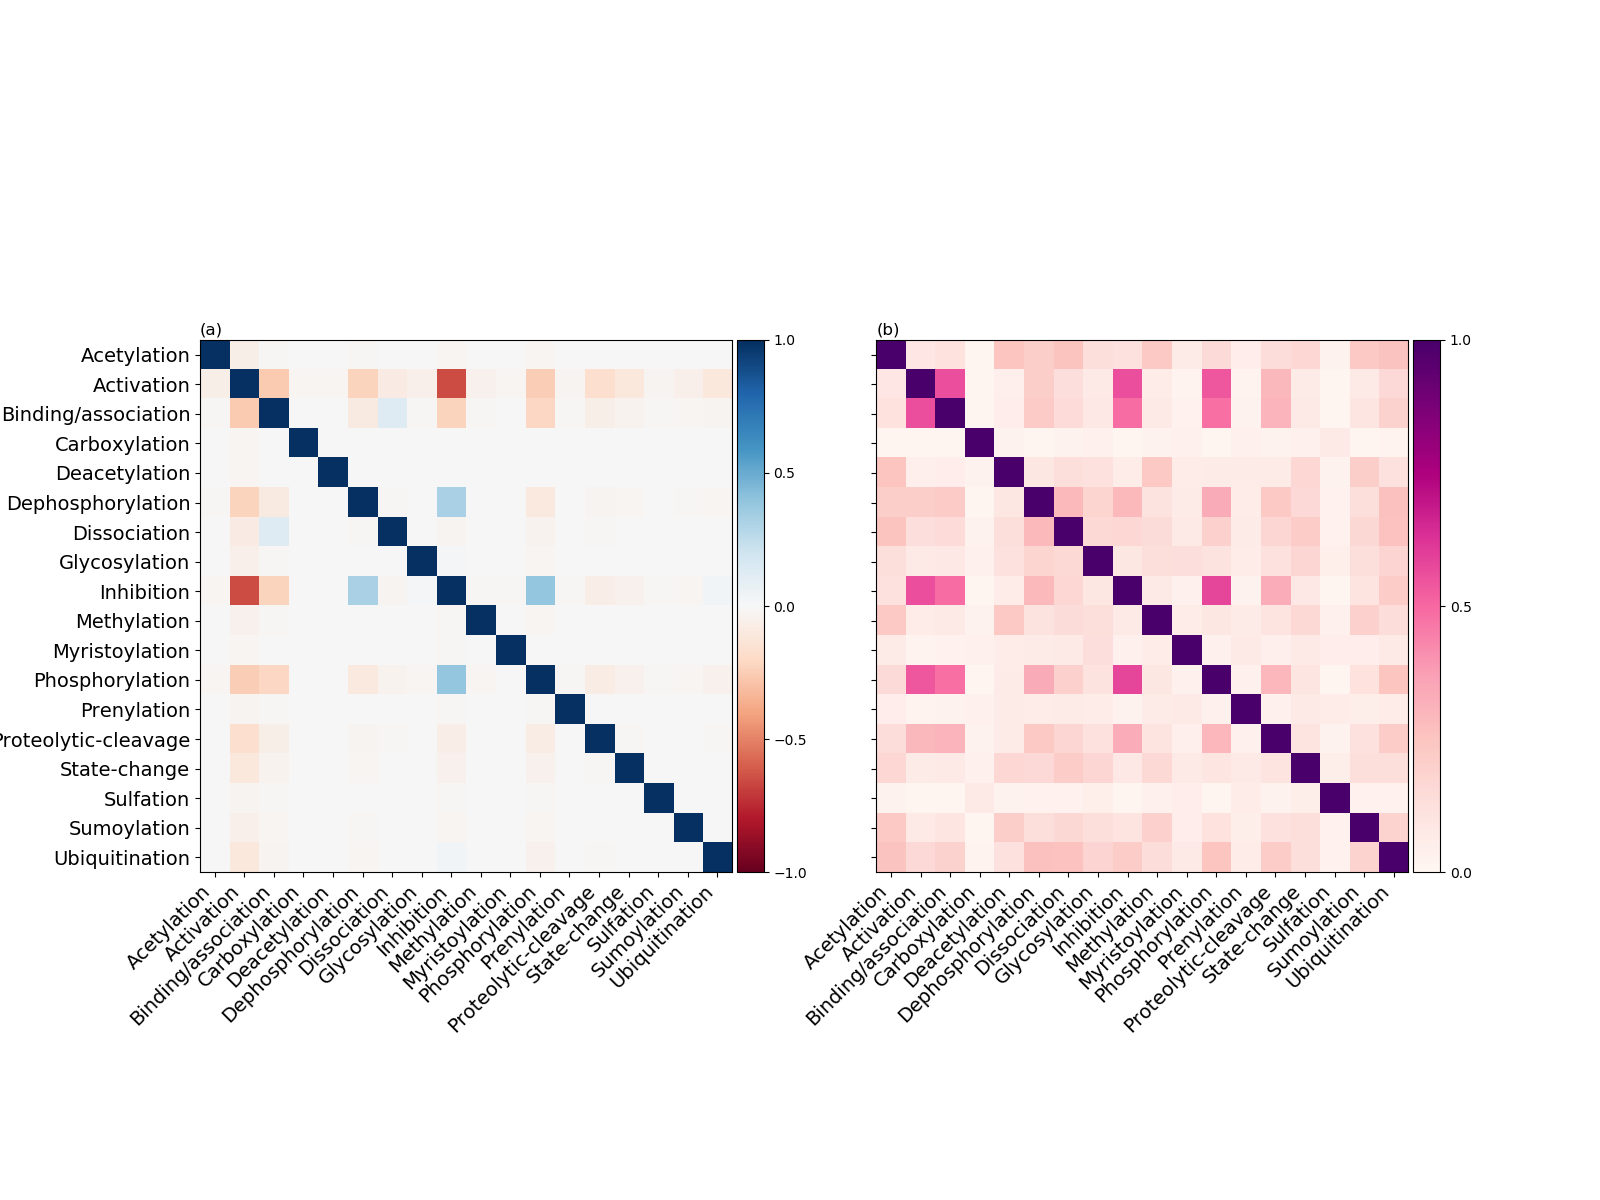

In [155]:
import string
from mpl_toolkits.axes_grid1 import make_axes_locatable

# data1 = np.genfromtxt("data/baseline/j_v_similarity_matrix.csv", skip_header=True, delimiter=',')
# data2 = np.genfromtxt("data/baseline/j_t_similarity_matrix.csv", skip_header=True, delimiter=',')

# v_ticklabels = [l.capitalize() for l in labels]
# t_ticklabels = [l.capitalize() for l in sorted(('phosphorylation', 'dephosphorylation'))]

# fig = plt.figure(figsize=(6, 8))
# gs = GridSpec(
#     1, 2, width_ratios=[1, 1], 
#     wspace=0.0, hspace=0.0, 
#     top=0.95, bottom=0.15, left=0.15, right=0.75
# )
# ax1 = plt.subplot(gs[0, 0])
# ax2 = plt.subplot(gs[0, 1])

# ax1.set_xticks(range(0, 18))
# ax1.set_xticklabels(v_ticklabels, rotation=315, ha='left', fontdict={'size': 7})
# ax1.set_yticks(range(0, 18))
# ax1.set_yticklabels(v_ticklabels, fontdict={'size': 7})

# ax2.set_xticks(range(0, 18))
# ax2.set_xticklabels(t_ticklabels, rotation=315, ha='left', fontdict={'size': 7})
# ax2.set_yticks(range(0, 18))
# ax2.set_yticklabels(v_ticklabels, fontdict={'size': 7})
    
# im1 = ax1.imshow(data1, interpolation='none', cmap='RdPu', vmin=0, vmax=1)
# im2 = ax2.imshow(data2.T, interpolation='none', cmap='RdPu', vmin=0, vmax=1)

# fig.colorbar(im1)

# plt.tight_layout()
# plt.show()

data1 = np.genfromtxt("data/baseline/label_spearmanr.csv", skip_header=True, delimiter=',')
data2 = np.genfromtxt("data/baseline/j_v_similarity_matrix.csv", skip_header=True, delimiter=',')
ticklabels = [l.capitalize() for l in labels]


fig = plt.figure(figsize=(16, 12))
gs = GridSpec(1, 2)
gs.update(**dict(wspace=0.2))
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1], sharey=ax1)

#-- Label sim
ax1.set_xticks(range(0, 18))
ax1.set_xticklabels(ticklabels, rotation=45, ha='right', fontdict={'size': 14})

ax1.set_yticks(range(0, 18))
ax1.set_yticklabels(ticklabels, fontdict={'size': 14})
ax1.text(0, 1.01, '(a)', transform=ax1.transAxes, size=12)

im1 = ax1.imshow(data1, interpolation='none', cmap='RdBu', vmin=-1, vmax=1)
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im1, cax=cax1, ticks=[-1., -0.5, 0., 0.5, 1.])


#-- Jacard
ax2.set_xticks(range(0, 18))
ax2.set_xticklabels(ticklabels, rotation=45, ha='right', fontdict={'size': 14})

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.text(0, 1.01, '(b)', transform=ax2.transAxes, size=12)

im2 = ax2.imshow(data2, interpolation='none', cmap='RdPu', vmin=0, vmax=1)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im2, cax=cax2, ticks=[0., .5, 1.])

plt.savefig('maps.jpg', format='jpg', dpi=350, bbox_inches='tight', pad_inches=0)
plt.show()

# Paper Figure 3

This code computes the threshold curve giving the proportion of the interactome classified at a probability threshold t or greater.

<IPython.core.display.Javascript object>


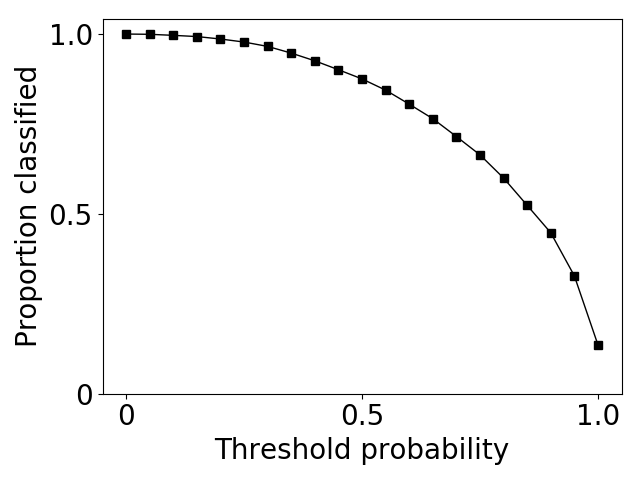

In [15]:
thresholds = []
proportions = []
with open('data/pred_baseline/thresholds.csv', 'rt') as fp:
    reader = csv.reader(fp)
    for row in reader:
        thresholds.append(float(row[0]))
        proportions.append(float(row[1]))

plt.style.use('default')
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, proportions, 's-', color='black', linewidth='1', )
ax.set_xticks([0, 0.5, 1.0])
ax.set_xticklabels([0, 0.5, 1.0], fontdict={'size': 20})
ax.set_yticks([0, 0.5, 1.0])
ax.set_yticklabels([0, 0.5, 1.0], fontdict={'size': 20})
ax.set_ylabel("Proportion classified", fontdict={'size': 20})
ax.set_xlabel("Threshold probability", fontdict={'size': 20})

plt.tight_layout()
plt.savefig('threshold.jpg', format='jpg', dpi=350, bbox_inches='tight', pad_inches=0)
plt.show()